In [ ]:
# Insurance Cost Prediction (EDA + ML)

**Goal:** Predict medical insurance charges (`charges`) using policyholder attributes (age, BMI, smoker status, region, etc.).

This notebook covers:
1. Data checks + cleaning summary  
2. Exploratory Data Analysis (EDA)  
3. Baseline model (Linear Regression)  
4. Improved model (Random Forest)  
5. Feature importance + saved model artifact

In [1]:
import pandas as pd
import numpy as np

DATA_PATH = "../data/raw/insurance.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())
print("\nDtypes:\n", df.dtypes)
print("\nMissing values:\n", df.isna().sum())
print("\nBasic stats (numeric):\n", df.describe())

Shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520



Dtypes:
 age           int64
sex             str
bmi         float64
children      int64
smoker          str
region          str
charges     float64
dtype: object

Missing values:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Basic stats (numeric):
                age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


In [2]:
# Basic sanity checks
print("Duplicate rows:", df.duplicated().sum())
print("\nUnique values per categorical column:")
for col in ["sex", "smoker", "region"]:
    print(f"- {col}: {df[col].nunique()} -> {sorted(df[col].unique())}")

print("\nCharges summary:")
display(df["charges"].describe())

Duplicate rows: 1

Unique values per categorical column:
- sex: 2 -> ['female', 'male']
- smoker: 2 -> ['no', 'yes']
- region: 4 -> ['northeast', 'northwest', 'southeast', 'southwest']

Charges summary:


count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

In [3]:
# Remove duplicate rows
df_clean = df.drop_duplicates().reset_index(drop=True)

df_clean = pd.read_csv("../data/processed/insurance_clean.csv")

print("Original shape:", df.shape)
print("Cleaned shape:", df_clean.shape)

# Save cleaned data
OUT_PATH = "../data/processed/insurance_clean.csv"
df_clean.to_csv(OUT_PATH, index=False)
print("Saved:", OUT_PATH)

Original shape: (1338, 7)
Cleaned shape: (1337, 7)
Saved: ../data/processed/insurance_clean.csv


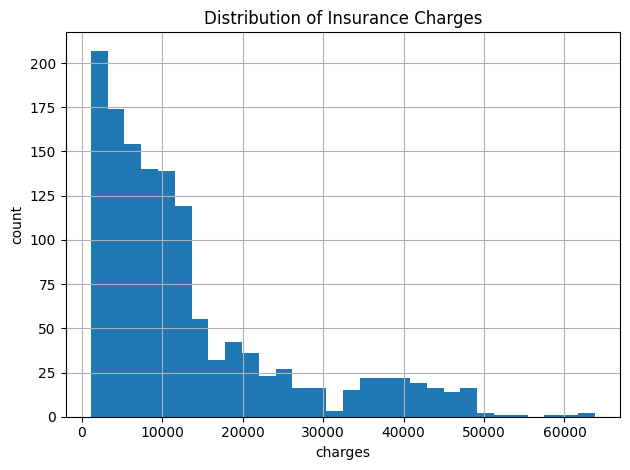

<Figure size 640x480 with 0 Axes>

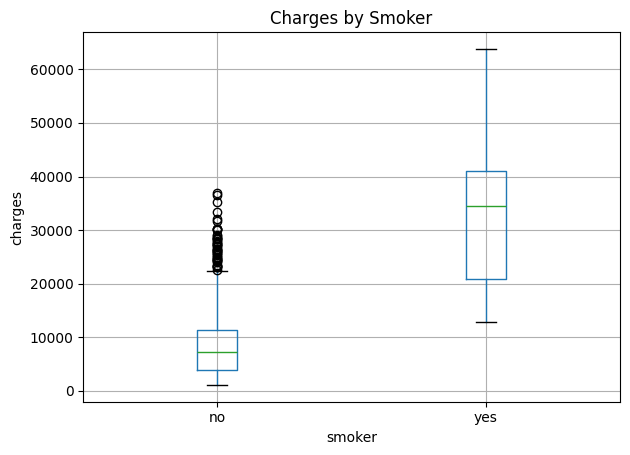

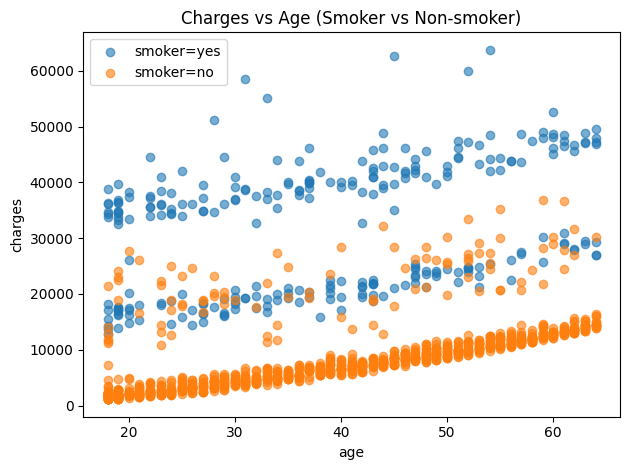

Saved 3 plots to ../reports/figures/


In [4]:
import os
import matplotlib.pyplot as plt

os.makedirs("../reports/figures", exist_ok=True)

# 1) Charges distribution
plt.figure()
df_clean["charges"].hist(bins=30)
plt.title("Distribution of Insurance Charges")
plt.xlabel("charges")
plt.ylabel("count")
plt.tight_layout()
plt.savefig("../reports/figures/charges_distribution.png", dpi=200)
plt.show()

# 2) Charges by smoker
plt.figure()
df_clean.boxplot(column="charges", by="smoker")
plt.title("Charges by Smoker")
plt.suptitle("")
plt.xlabel("smoker")
plt.ylabel("charges")
plt.tight_layout()
plt.savefig("../reports/figures/charges_by_smoker.png", dpi=200)
plt.show()

# 3) Charges vs age (smoker vs non-smoker)
plt.figure()
for s in df_clean["smoker"].unique():
    subset = df_clean[df_clean["smoker"] == s]
    plt.scatter(subset["age"], subset["charges"], label=f"smoker={s}", alpha=0.6)
plt.title("Charges vs Age (Smoker vs Non-smoker)")
plt.xlabel("age")
plt.ylabel("charges")
plt.legend()
plt.tight_layout()
plt.savefig("../reports/figures/charges_vs_age_smoker.png", dpi=200)
plt.show()

print("Saved 3 plots to ../reports/figures/")

In [5]:
# “Baseline Linear Regression: MAE…, RMSE…, R²…”

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Features/target
X = df_clean.drop(columns=["charges"])
y = df_clean["charges"]

# Column groups
cat_cols = ["sex", "smoker", "region"]
num_cols = ["age", "bmi", "children"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocessing
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
    ]
)

# Model
model = LinearRegression()

# Full pipeline
pipeline = Pipeline(steps=[("preprocess", preprocess), ("model", model)])

# Train
pipeline.fit(X_train, y_train)

# Predict + metrics
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²:   {r2:.4f}")

MAE:  4,177.05
RMSE: 5,956.34
R²:   0.8069


In [6]:
# “Random Forest: MAE…, RMSE…, R²…”

from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print(f"Random Forest MAE:  {rf_mae:,.2f}")
print(f"Random Forest RMSE: {rf_rmse:,.2f}")
print(f"Random Forest R²:   {rf_r2:.4f}")

Random Forest MAE:  2,644.65
Random Forest RMSE: 4,700.17
Random Forest R²:   0.8798


,feature,importance
4,smoker_yes,0.598729
1,bmi,0.216322
0,age,0.137946
2,children,0.022736
3,sex_male,0.006970
5,region_northwest,0.006499
6,region_southeast,0.006253
7,region_southwest,0.004544


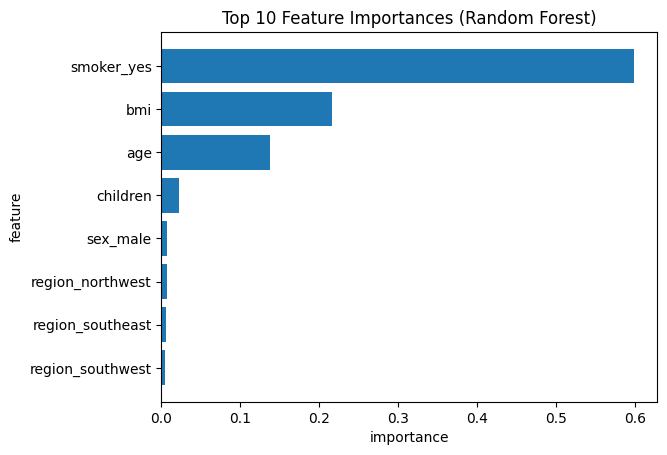

In [7]:
# Get feature names after preprocessing
ohe = rf_pipeline.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

feature_names = np.concatenate([num_cols, cat_feature_names])

importances = rf_pipeline.named_steps["model"].feature_importances_

fi = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
)

display(fi.head(10))

# Plot top 10
import matplotlib.pyplot as plt

plt.figure()
plt.barh(fi.head(10)["feature"][::-1], fi.head(10)["importance"][::-1])
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("importance")
plt.ylabel("feature")
plt.show()

In [8]:
import joblib
from pathlib import Path

Path("../models").mkdir(exist_ok=True)

MODEL_PATH = "../models/insurance_cost_model_rf.joblib"
joblib.dump(rf_pipeline, MODEL_PATH)

print("Saved model to:", MODEL_PATH)

Saved model to: ../models/insurance_cost_model_rf.joblib


In [9]:
import pandas as pd
import joblib

MODEL_PATH = "../models/insurance_cost_model_rf.joblib"
loaded_model = joblib.load(MODEL_PATH)

# Example policyholder (you can change values)
sample = pd.DataFrame([{
    "age": 30,
    "sex": "male",
    "bmi": 28.5,
    "children": 1,
    "smoker": "no",
    "region": "southeast"
}])

pred = loaded_model.predict(sample)[0]
print("Predicted insurance charges:", round(pred, 2))

Predicted insurance charges: 4631.39
